In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
chunks = pd.read_json('../data/train.jsonl', lines=True, chunksize=100_000)

In [3]:
train = pd.DataFrame()

In [4]:
for i, chunk in enumerate(chunks):
    event_dict = {
        'session': [],
        'aid':     [],
        'ts':      [],
        'type':    []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                               chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    train = pd.concat([train, chunk_session])

In [5]:
train = train.reset_index(drop=True)

In [6]:
display(train)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [7]:
train.rename(index=str, columns={'session': 'customer_id',
                                  'aid' : 'product_code',
                                  'ts' : 'time_stamp',
                                  'type' : 'event_type'}, inplace=True)

In [8]:
display(train)

,customer_id,product_code,time_stamp,event_type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [10]:
grouped_train = train.groupby('customer_id').count()

In [11]:
display(grouped_train)

,product_code,time_stamp,event_type
customer_id,,,
0,276,276,276
1,32,32,32
2,33,33,33
3,226,226,226
4,19,19,19
...,...,...,...
199995,17,17,17
199996,25,25,25
199997,154,154,154


### Per customer statistics

From the selected subset of 200k customers, on average we see a user clicks, add to cart or order around 51 products with a standard deviation of 75. Maximum number of events in a customer session is 495 and minimum session is 2, indicating potentially a long tail of customer sessions with relatively large number of events. 

In [15]:
grouped_train.describe()

,product_code,time_stamp,event_type
count,200000.000000,200000.000000,200000.000000
mean,51.427805,51.427805,51.427805
std,75.456583,75.456583,75.456583
min,2.000000,2.000000,2.000000
25%,6.000000,6.000000,6.000000
50%,19.000000,19.000000,19.000000
75%,62.000000,62.000000,62.000000
max,495.000000,495.000000,495.000000


### Distribution of number of products viewed by customers

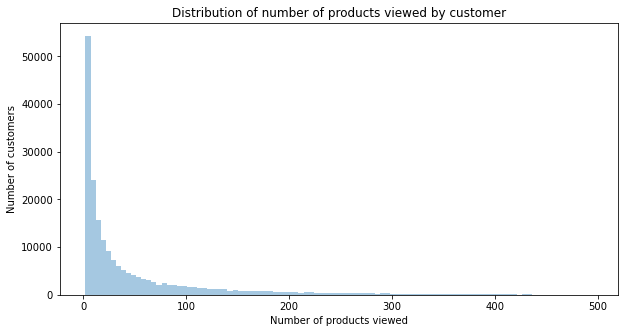

In [20]:
plt.figure(figsize=(10, 5))
sns.distplot(grouped_train['product_code'], kde=False, bins=100)
plt.title('Distribution of number of products viewed by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of customers')
plt.show()

### Event distribution across entire usebase

Majority of the events in the sampled data are clicks, followed by addition to carts and orders. It is evident that a very small chunk of customers sessions translate to a conversion. At this point it will be interesting to understand the relationship b/w length of the session and the conversion rate.

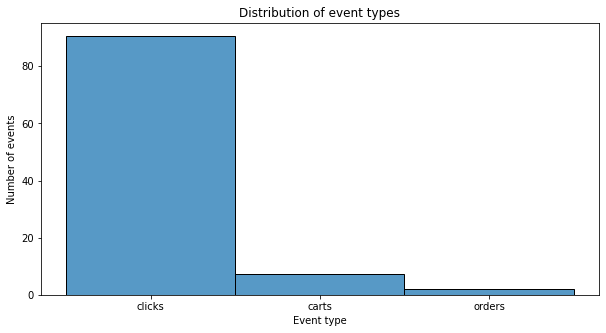

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(train['event_type'], stat='percent', kde=False, bins=100)
plt.title('Distribution of event types')
plt.xlabel('Event type')
plt.ylabel('Number of events')
plt.show()

In [35]:
grouped_train_orders = train[train['event_type'] == 'orders'].groupby('customer_id').count().join(grouped_train, lsuffix='_orders', rsuffix='_views')   
grouped_train_orders = grouped_train_orders.drop(['product_code_views', 'time_stamp_views'], axis=1).rename(columns={'event_type_views': 'event_count'})

In [36]:
display(grouped_train_orders)

,product_code_orders,time_stamp_orders,event_type_orders,event_count
customer_id,,,,
0,4,4,4,276
3,5,5,5,226
4,1,1,1,19
11,2,2,2,93
12,1,1,1,5
...,...,...,...,...
199980,1,1,1,32
199985,4,4,4,37
199991,2,2,2,27


### Number of products viewed vs. number of products ordered

There seems to be a slight correlation b/w number of products viewed vs number of products ordered by a customer. 

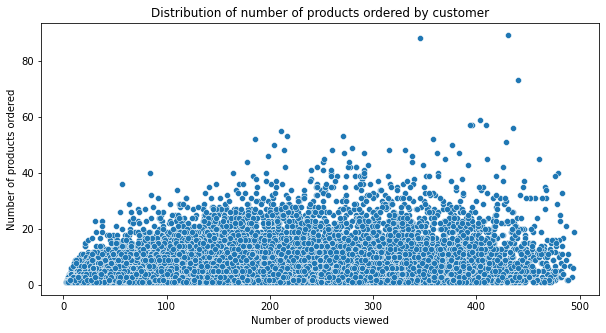

In [41]:
# plot trend between event count and event type orders
plt.figure(figsize=(10, 5))
sns.scatterplot(x=grouped_train_orders['event_count'], y=grouped_train_orders['product_code_orders'])
plt.title('Distribution of number of products ordered by customer')
plt.xlabel('Number of products viewed')
plt.ylabel('Number of products ordered')
plt.show()